**Chapter 15 – Autoencoders**

_This notebook contains all the sample code and solutions to the exercices in chapter 15._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os
import sys

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale 28x28 image:

In [2]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [3]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [4]:
rnd.seed(4)
m = 100
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
X_train = np.empty((m, 3))
X_train[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
X_train[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
X_train[:, 2] = X_train[:, 0] * w1 + X_train[:, 1] * w2 + noise * rnd.randn(m)

Normalize the data:

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

Going to need TensorFlow...

In [6]:
import tensorflow as tf

Now let's build the Autoencoder:

In [7]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = fully_connected(X, n_hidden, activation_fn=None)
outputs = fully_connected(hidden, n_outputs, activation_fn=None)

mse = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [8]:
n_iterations = 10000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_train})

Saving figure linear_autoencoder_pca_plot


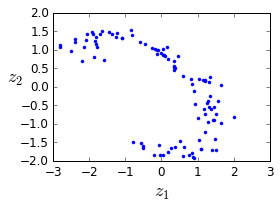

In [9]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

In [11]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

initializer = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#initializer = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
with tf.contrib.framework.arg_scope(
        [fully_connected],
        activation_fn=tf.nn.elu,
        weights_initializer=initializer,
        weights_regularizer=tf.contrib.layers.l2_regularizer(l2_reg)):
    hidden1 = fully_connected(X, n_hidden1)
    hidden2 = fully_connected(hidden1, n_hidden2)
    hidden3 = fully_connected(hidden2, n_hidden3)
    outputs = fully_connected(hidden3, n_outputs, activation_fn=None)

mse = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = mse + reg_losses

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now let's train it! Note that we don't feed target values (`y_batch` is not used). This is unsupervised training.

In [12]:
n_epochs = 4
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        mse_train = mse.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", mse_train)
        saver.save(sess, "./my_model_all_layers.ckpt")

0 Train MSE: 0.0319748
1 Train MSE: 0.0179479
2 Train MSE: 0.0129299
3 Train MSE: 0.00947758


This function loads the model, evaluates it on the test set (it measures the reconstruction error), then it displays the original image and its reconstruction:

In [13]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

Saving figure reconstruction_plot


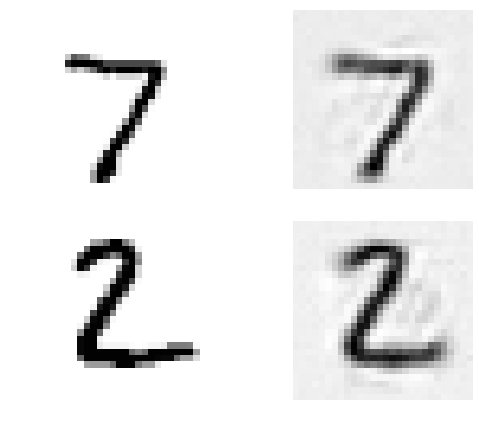

In [14]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

## Training one Autoencoder at a time in multiple graphs

There are many ways to train one Autoencoder at a time. The first approach it to train each Autoencoder using a different graph, then we create the Stacked Autoencoder by simply initializing it with the weights and biases copied from these Autoencoders.

Let's create a function that will train one autoencoder and return the transformed training set (ie. the output of the hidden layer) and the model parameters.

In [15]:
def train_autoencoder(X_train, n_neurons, n_epochs, batch_size, learning_rate = 0.01, l2_reg = 0.0005, activation_fn=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        with tf.contrib.framework.arg_scope(
                [fully_connected],
                activation_fn=activation_fn,
                weights_initializer=tf.contrib.layers.variance_scaling_initializer(),
                weights_regularizer=tf.contrib.layers.l2_regularizer(l2_reg)):
            hidden = fully_connected(X, n_neurons, scope="hidden")
            outputs = fully_connected(hidden, n_inputs, activation_fn=None, scope="outputs")

        mse = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = mse + reg_losses

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            mse_train = mse.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", mse_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/weights:0"], params["hidden/biases:0"], params["outputs/weights:0"], params["outputs/biases:0"]

Now let's train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output:

In [16]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.0129975
1 Train MSE: 0.0129642
2 Train MSE: 0.0130323
3 Train MSE: 0.0133927
0 Train MSE: 0.00313369
1 Train MSE: 0.00342821
2 Train MSE: 0.00363107
3 Train MSE: 0.0037358


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained:

In [17]:
tf.reset_default_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

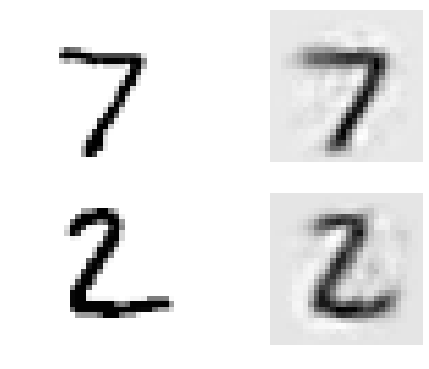

In [18]:
show_reconstructed_digits(X, outputs)

## Training one Autoencoder at a time in a single graph

Another approach is to use a single graph. To do this, we create the graph for the full Stacked Autoencoder, but then we also add operations to train each Autoencoder independently: phase 1 trains the bottom and top layer (ie. the first Autoencoder) and phase 2 trains the two middle layers (ie. the second Autoencoder).

In [19]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4


with tf.name_scope("phase1"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_mse = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_mse + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    phase2_mse = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_mse + phase2_reg_loss
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=[weights2, biases2, weights3, biases3]) # freeze hidden1
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [20]:
training_ops = [phase1_training_op, phase2_training_op]
mses = [phase1_mse, phase2_mse]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            mse_train = mses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", mse_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    mse_test = mses[phase].eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", mse_test)

Training phase #1
0 Train MSE: 0.0077799
1 Train MSE: 0.00749564
2 Train MSE: 0.00773762
3 Train MSE: 0.00780849
Training phase #2
0 Train MSE: 0.00227434
1 Train MSE: 0.00267451
2 Train MSE: 0.00249404
3 Train MSE: 0.00275205
Test MSE: 0.00303329


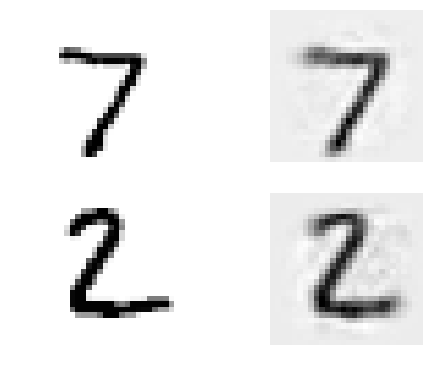

In [21]:
show_reconstructed_digits(X, outputs, "./my_model_one_at_a_time.ckpt")

## Cache the frozen layer outputs

In [22]:
training_ops = [phase1_training_op, phase2_training_op, training_op]
mses = [phase1_mse, phase2_mse, mse]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            mnist_hidden1 = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(len(mnist_hidden1))
                    hidden1_batch = mnist_hidden1[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            mse_train = mses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", mse_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    mse_test = mses[phase].eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", mse_test)

Training phase #1
0 Train MSE: 0.0072861
1 Train MSE: 0.00790681
2 Train MSE: 0.00777492
3 Train MSE: 0.00778348
Training phase #2
0 Train MSE: 0.00234328
1 Train MSE: 0.00248873
2 Train MSE: 0.00271144
3 Train MSE: 0.00268969
Test MSE: 0.0028896


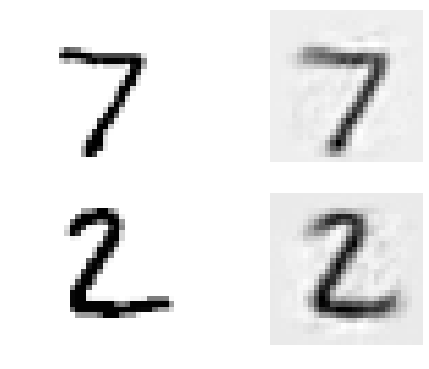

In [23]:
show_reconstructed_digits(X, outputs, "./my_model_cache_frozen.ckpt")

## Tying weights

It is common to tie the weights of the encoder and the decoder (`weights_decoder = tf.transpose(weights_encoder)`). Unfortunately this makes it impossible (or very tricky) to use the `fully_connected()` function, so we need to build the Autoencoder manually:

In [24]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

mse = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = mse + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [25]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        mse_train = mse.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", mse_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.0167529
1 Train MSE: 0.0164158
2 Train MSE: 0.0162873
3 Train MSE: 0.0171566
4 Train MSE: 0.0161259


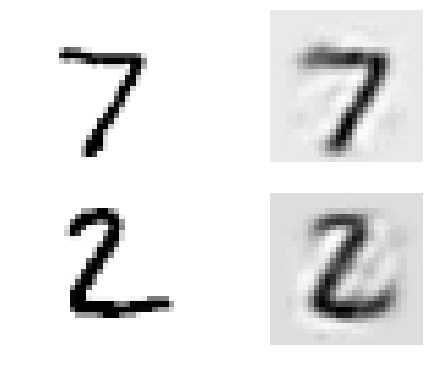

In [26]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

# Unsupervised pretraining

In [27]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

Regular training (without pretraining):

In [28]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.953333 Test accuracy: 0.9271
1 Train accuracy: 0.966667 Test accuracy: 0.9261
29% Train accuracy: 0.946667 Test accuracy: 0.9468
3 Train accuracy: 0.973333 Test accuracy: 0.9543


Now reusing the first two layers of the autoencoder we pretrained:

In [29]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.9	Test accuracy: 0.9102
1 Train accuracy: 0.966667	Test accuracy: 0.9387
2 Train accuracy: 0.953333	Test accuracy: 0.9488
3 Train accuracy: 0.96	Test accuracy: 0.9482


# Stacked denoising Autoencoder

In [30]:
tf.reset_default_graph()

from tensorflow.contrib.layers import dropout

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.00001
keep_prob = 0.7

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
is_training = tf.placeholder_with_default(False, shape=(), name='is_training')

X_drop = dropout(X, keep_prob, is_training=is_training)

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X_drop, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

optimizer = tf.train.AdamOptimizer(learning_rate)
mse = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = mse + reg_loss
training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [31]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, is_training: True})
        mse_train = mse.eval(feed_dict={X: X_batch, is_training: False})
        print("\r{}".format(epoch), "Train MSE:", mse_train)
        saver.save(sess, "./my_model_stacked_denoising.ckpt")

0 Train MSE: 0.0184146
1 Train MSE: 0.0127358
2 Train MSE: 0.0102313
3 Train MSE: 0.00965831
4 Train MSE: 0.00924804
5 Train MSE: 0.0088919
6 Train MSE: 0.00885094
7 Train MSE: 0.0090364
8 Train MSE: 0.00841659
9 Train MSE: 0.00865683


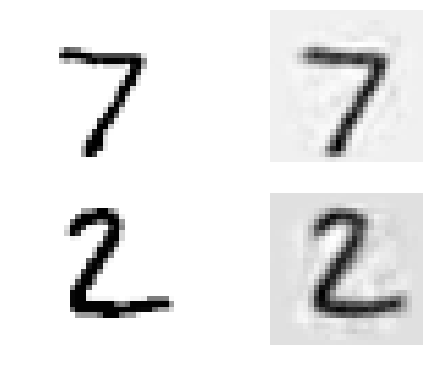

In [32]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising.ckpt")

## Visualizing the extracted features

In [33]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_stacked_denoising.ckpt")
    weights1_val = weights1.eval()

Saving figure extracted_features_plot


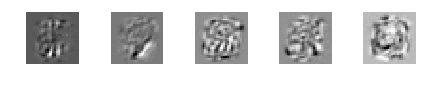

In [34]:
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

save_fig("extracted_features_plot")
plt.show()

# Sparse Autoencoder

/home/ageron/dev/py/envs/mltst/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


Saving figure sparsity_loss_plot


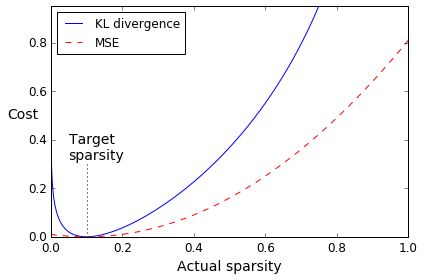

In [35]:
p = 0.1
q = np.linspace(0, 1, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [36]:
def kl_divergence(p, q):
    """Kullback Leibler divergence"""
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

In [37]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

#activation = tf.nn.softplus # soft variant of ReLU
activation = tf.nn.sigmoid
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_outputs), name="biases2")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
outputs = tf.matmul(hidden1, weights2) + biases2

optimizer = tf.train.AdamOptimizer(learning_rate)
mse = tf.reduce_mean(tf.square(outputs - X))

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
loss = mse + sparsity_weight * sparsity_loss
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [38]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        mse_val, sparsity_loss_val, loss_val = sess.run([mse, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", mse_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.0817271 	Sparsity loss: 0.384313 	Total loss: 0.15859
1 Train MSE: 0.0547101 	Sparsity loss: 0.133792 	Total loss: 0.0814684
2 Train MSE: 0.0491168 	Sparsity loss: 0.102076 	Total loss: 0.0695321
3 Train MSE: 0.0427555 	Sparsity loss: 0.0580622 	Total loss: 0.0543679
4 Train MSE: 0.0388306 	Sparsity loss: 0.258078 	Total loss: 0.0904461
5 Train MSE: 0.0350311 	Sparsity loss: 0.0247787 	Total loss: 0.0399869
6 Train MSE: 0.0312519 	Sparsity loss: 0.0519023 	Total loss: 0.0416324
7 Train MSE: 0.0282995 	Sparsity loss: 0.0559849 	Total loss: 0.0394964
8 Train MSE: 0.0268548 	Sparsity loss: 0.0824516 	Total loss: 0.0433452
9 Train MSE: 0.0252737 	Sparsity loss: 0.101543 	Total loss: 0.0455822
10 Train MSE: 0.022887 	Sparsity loss: 0.14663 	Total loss: 0.052213
11 Train MSE: 0.0230027 	Sparsity loss: 0.177287 	Total loss: 0.0584601
12 Train MSE: 0.0208771 	Sparsity loss: 0.0856517 	Total loss: 0.0380074
13 Train MSE: 0.0193335 	Sparsity loss: 0.0664709 	Total loss: 0.0326276


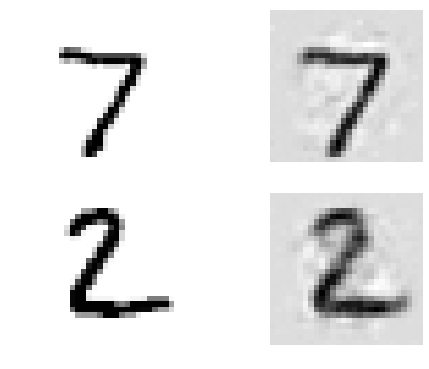

In [39]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

# Variational Autoencoder

In [40]:
tf.reset_default_graph()

n_inputs = 28*28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001

activation = tf.nn.elu
initializer = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG",
                                                             uniform=True)

X = tf.placeholder(tf.float32, [None, n_inputs])

weights1 = tf.Variable(initializer([n_inputs, n_hidden1]))
weights2 = tf.Variable(initializer([n_hidden1, n_hidden2]))
weights3_mean = tf.Variable(initializer([n_hidden2, n_hidden3]))
weights3_log_sigma = tf.Variable(initializer([n_hidden2, n_hidden3]))
weights4 = tf.Variable(initializer([n_hidden3, n_hidden4]))
weights5 = tf.Variable(initializer([n_hidden4, n_hidden5]))
weights6 = tf.Variable(initializer([n_hidden5, n_inputs]))

biases1 = tf.Variable(tf.zeros([n_hidden1], dtype=tf.float32))
biases2 = tf.Variable(tf.zeros([n_hidden2], dtype=tf.float32))
biases3_mean = tf.Variable(tf.zeros([n_hidden3], dtype=tf.float32))
biases3_log_sigma = tf.Variable(tf.zeros([n_hidden3], dtype=tf.float32))
biases4 = tf.Variable(tf.zeros([n_hidden4], dtype=tf.float32))
biases5 = tf.Variable(tf.zeros([n_hidden5], dtype=tf.float32))
biases6 = tf.Variable(tf.zeros([n_inputs], dtype=tf.float32))

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)

hidden3_mean = tf.matmul(hidden2, weights3_mean) + biases3_mean
hidden3_log_sigma = tf.matmul(hidden2, weights3_log_sigma) + biases3_log_sigma
noise = tf.random_normal(tf.shape(hidden3_log_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.sqrt(tf.exp(hidden3_log_sigma)) * noise

hidden4 = activation(tf.matmul(hidden3, weights4) + biases4)
hidden5 = activation(tf.matmul(hidden4, weights5) + biases5)
logits = tf.matmul(hidden5, weights6) + biases6
outputs = tf.sigmoid(logits)

reconstruction_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits))
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_log_sigma) + tf.square(hidden3_mean) - 1 - hidden3_log_sigma)
cost = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(cost)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [41]:
tf.reset_default_graph()

n_inputs = 28*28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

with tf.contrib.framework.arg_scope([fully_connected],
                                    activation_fn=tf.nn.elu,
                                    weights_initializer=initializer):
    X = tf.placeholder(tf.float32, [None, n_inputs])
    hidden1 = fully_connected(X, n_hidden1)
    hidden2 = fully_connected(hidden1, n_hidden2)
    hidden3_mean = fully_connected(hidden2, n_hidden3, activation_fn=None)
    hidden3_gamma = fully_connected(hidden2, n_hidden3, activation_fn=None)
    noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
    hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
    hidden4 = fully_connected(hidden3, n_hidden4)
    hidden5 = fully_connected(hidden4, n_hidden5)
    logits = fully_connected(hidden5, n_outputs, activation_fn=None)
    outputs = tf.sigmoid(logits)

reconstruction_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits))
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
cost = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(cost)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        cost_val, reconstruction_loss_val, latent_loss_val = sess.run([cost, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train cost:", cost_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train cost: 18606.2 	Reconstruction loss: 14819.0 	Latent loss: 3787.25
1 Train cost: 16776.8 	Reconstruction loss: 13075.5 	Latent loss: 3701.32
2 Train cost: 16465.2 	Reconstruction loss: 12710.3 	Latent loss: 3754.91
3 Train cost: 16599.6 	Reconstruction loss: 12777.0 	Latent loss: 3822.65
4 Train cost: 16195.2 	Reconstruction loss: 12320.3 	Latent loss: 3874.92
5 Train cost: 16021.1 	Reconstruction loss: 12250.5 	Latent loss: 3770.53
6 Train cost: 15870.0 	Reconstruction loss: 12095.8 	Latent loss: 3774.19
7 Train cost: 16136.7 	Reconstruction loss: 12267.2 	Latent loss: 3869.49
8 %Train cost: 15875.1 	Reconstruction loss: 12092.0 	Latent loss: 3783.13
9 Train cost: 15580.6 	Reconstruction loss: 11930.5 	Latent loss: 3650.03
10 Train cost: 16030.2 	Reconstruction loss: 12270.3 	Latent loss: 3759.87
11 Train cost: 15378.9 	Reconstruction loss: 11545.0 	Latent loss: 3833.88
12 Train cost: 15337.2 	Reconstruction loss: 11546.4 	Latent loss: 3790.84
13 Train cost: 15994.3 	Reconstruc

Encode:

In [43]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

Decode:

In [44]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

Let's plot the reconstructions:

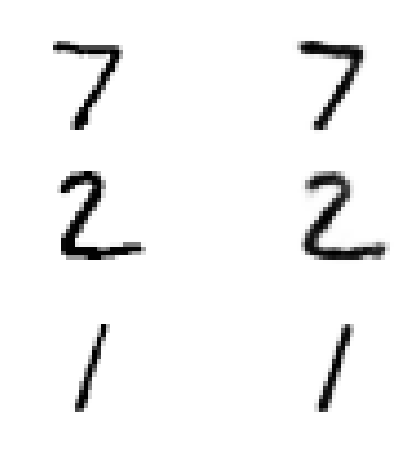

In [45]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

## Generate digits

In [46]:
n_rows = 6
n_cols = 10
n_digits = n_rows * n_cols
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_rnd})

Saving figure generated_digits_plot


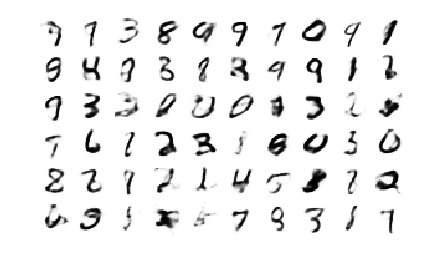

In [47]:
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
save_fig("generated_digits_plot")
plt.show()

In [48]:
n_rows = 6
n_cols = 10
n_digits = n_rows * n_cols
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_rnd})

## Interpolate digits

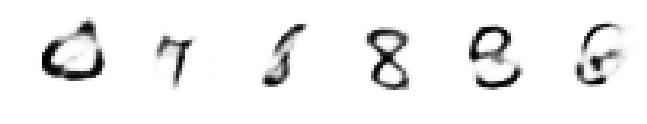

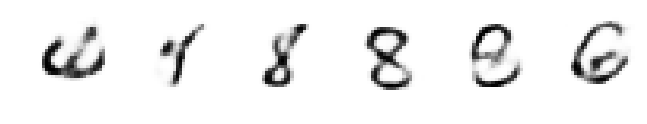

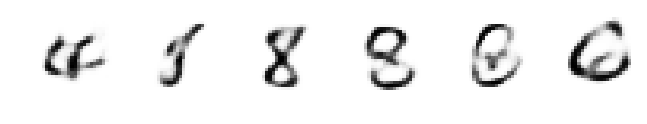

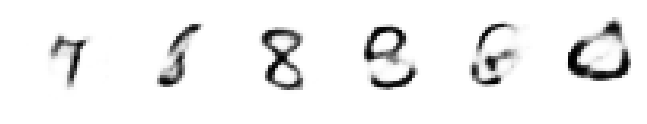

In [49]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()

# Exercise solutions

Coming soon...